# NetMorph
- http://www.scholarpedia.org/article/NETMORPH
- https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0085858
- https://link.springer.com/article/10.1007/s12021-009-9052-3
- https://jvanpelt.nl/
- https://bsd.neuroinf.jp/wiki/%E9%8C%90%E4%BD%93%E7%B4%B0%E8%83%9E
- https://www.neurodynamics.nl/NETMORPH/netmorph_scripts.html

- diameterは省略．
- netmorph -> vision map
- 本書では取り扱わないが，層構造や脳の全体のシミュレーションもある．
- van_Pelt_branching_model

### 分岐
時刻$[t_i, t_i + \Delta t]$において，$j$番目の末端分節(terminal segment)が分岐する確率は
$$
p_{i,j} = n_i^{-E}\cdot B_{\infty} e^{\frac{-t_i}{\tau}} \left(e^{\frac{\Delta t}{\tau}} - 1\right)\cdot \frac{2^{-S\gamma_j}}{C_{n_i}}
$$
で表される．ここで，$B_{\infty}, E, S, \tau$は定数である．$\gamma_j$は$j$番目の末端分節の階層(centrifugal order)であり，$n_i$は時刻$t_i$における末端分節の総計である．さらに

$$
{C_{n_i}} = \frac{1}{n_i}\sum\nolimits_{k = 1}^{n_i} {{2^{ - S{\gamma_k}}}}
$$

とする．

### 伸長と角度

### 分岐時の角度と長さ
平行四辺形？

$$
\begin{align}
x &= r \sin\theta \cos\phi\\
y &= r \sin\theta \sin\phi\\
z &= r \cos\theta
\end{align}
$$

### ToDo
- 分岐時の角度（平行四辺形）
- 角度の上限 
- 3D化は読者に任せる？

In [1]:
using Base: @kwdef
using Parameters: @unpack # or using UnPack
using PyPlot, ProgressMeter, Distributions
rc("axes.spines", top=false, right=false)

In [2]:
function branching_prob(t, dt, γ, n, C, B∞, E, S, τ)
    return (n^(-E))*B∞*exp(-t/τ)*(exp(dt/τ) - 1)*(2^(-S*γ))/C
end

branching_prob (generic function with 1 method)

- tree_info (Int): 接続している分節の番号, 階層， 末端かどうかboolean
- seg_vec (Float): 分節のベクトル(x, y) -> (angle, length)

In [170]:
function segments_lines(tree_info, seg_vec, init_pos=nothing)
    num_segments = size(tree_info)[1]
    
    pos = zeros(num_segments, 2);
    if init_pos != nothing
        pos[1, :] = init_pos
    end
    
    for j in 1:num_segments
        pos[j, :] = pos[tree_info[j][1], :] + seg_vec[j][1] * [cos(seg_vec[j][2]), sin(seg_vec[j][2])]
    end
    
    lines = []
    for j in 1:num_segments
        x1, y1 = pos[tree_info[j][1], :]
        x2, y2 = pos[j, :]
        push!(lines, [(x1, y1), (x2, y2)])
    end
    return lines, pos
end

segments_lines (generic function with 2 methods)

- $r_L$ `turn_rate`: 回転率($\mu m^{-1}$)

In [142]:
function simulation(tree_info_init, seg_vec_init, nt, dt, B∞, E, S, τ, μₑ, σₑ,
                    turn_rate=5, max_branch_angle=0.1π, max_turn_angle=5e-3π)
    tree_info = copy(tree_info_init)
    seg_vec = copy(seg_vec_init)
    num_branching = 0
    
    @showprogress for tt in 1:nt
        t = tt*dt
        n, C = 0.0, 0.0
        for j in 1:size(tree_info)[1]
            if tree_info[j][3] == 1
                n += 1
                C += 2 ^(-S*tree_info[j][2])
            end
        end
        C /= n
        for j in 1:size(tree_info)[1]
            if tree_info[j][3] == 1
                γ = tree_info[j][2]
                p_branch = branching_prob(t, dt, γ, n, C, B∞, E, S, τ)
                if p_branch > rand()
                    # Neurite branching
                    num_branching += 1
                    branch_lens = (μₑ .+ randn(2) * σₑ)*dt　# branch length
                    branch_angles = [1, -1] .* rand(Uniform(0, max_branch_angle), 2)
                    for k in 1:2
                        push!(tree_info, [j, γ+1, 1]) # add two branches
                        push!(seg_vec, [branch_lens[k], seg_vec[j][2]+branch_angles[k]])
                    end
                    tree_info[j][3] = 0 # reset centrifugal order of original branch
                else
                    # Neurite elongation
                    seg_len = (μₑ .+ randn() * σₑ)*dt
                    p_turn = turn_rate*seg_vec[j][1]
                    if p_turn > rand()
                        push!(tree_info, [j, γ, 1]) # add segment
                        seg_angle = seg_vec[j][2] + rand(Uniform(-max_turn_angle, max_turn_angle))
                        push!(seg_vec, [seg_len, seg_angle])
                        tree_info[j][3] = 0 # reset centrifugal order of original branch
                    else
                        seg_vec[j][1] += seg_len
                    end
                end
            end
        end
    end
    println("Num. branching: ", num_branching)
    return tree_info, seg_vec
end

simulation (generic function with 4 methods)

In [139]:
14*24*60*60

1209600

In [ ]:
# axon
#B∞=13.2; E=0.319; S=-0.205; τ=1681541; dt=200; 
#μₑ=2.14e-4; σₑ=3.98e-4;

# basal dendrite
#B∞=2.52; E=0.73; S=0.5; τ=259680; dt=200; 
#μₑ=9.14e-5; σₑ=3.66e-5;

# Main stem
#B∞=0.1; E=0; S=0; τ=4e5; dt=200; 
#μₑ=1.02e-3; σₑ=2.6e-5;

# Tuft
#B∞=2.5; E=0.3; S=1.0; τ=4e5; dt=200; 
#μₑ=2.25e-6; σₑ=4e-6;

# Obliques
#B∞=1.5; E=0.3; S=1.0; τ=5e5; dt=200; 
#μₑ=4e-5; σₑ=1e-6;

In [219]:
#B∞=13.2; E=0; S=0; τ=14*24*60*60; dt=200; 
#μₑ=2.25e-6; σₑ=4e-6;

# Main stem
#B∞=25; E=0.3; S=1.0; τ=4e5; dt=200; 
#μₑ=2.25e-6; σₑ=4e-6;

# Main stem, Tuft, axon, basal dendrite1, 2
B∞= [0.1, 10, 13.2, 2.52, 2.52]
E = [0, 0.39, 0.319, 0.73, 0.73]
S = [0, 0, -0.205, 0.5, 0.5]
τ = [4e5, 4e5, 4e5, 259680, 259680]
dt=200; 
μₑ= [1.02e-4, 2.25e-4, 2.14e-4, 9.14e-5, 9.14e-5]
σₑ= [2.6e-5, 4e-4, 3.98e-4, 3.66e-5, 3.66e-5]

turn_rate= [1, 5, 5, 5, 5]
max_branch_angle=[0.2π, 0.1π, 0.1π,0.1π,0.1π]
max_turn_angle=[1e-4π, 1e-2π,1e-2π,1e-2π,1e-2π]

"""
B∞= [0.1, 13.2, 2.52]
E = [0, 0.319, 0.73]
S = [0, -0.205, 0.5]
τ = [4e5, 1681541, 259680]
dt=200; 
μₑ= [1.02e-3, 2.14e-4, 9.14e-5]
σₑ= [2.6e-5, 3.98e-4, 3.66e-5]

turn_rate= [0.01, 5, 5]
max_branch_angle=[0.1π, 0.1π, 0.1π]
max_turn_angle=[1e-4π, 5e-3π, 5e-3π]
"""
T = 18*24*60*60 # 18 days to sec
nt = round(Int, T/dt);

配列にcatするよりlist化してpush!の方が高速．

In [204]:
init_dir = [π/2, π/2, -π/2, -π/4, 5π/4]

5-element Vector{Float64}:
  1.5707963267948966
  1.5707963267948966
 -1.5707963267948966
 -0.7853981633974483
  3.9269908169872414

In [205]:
label = ["Main stem", "Tuft", "axon", "basal dendrite", "basal dendrite2"]

5-element Vector{String}:
 "Main stem"
 "Tuft"
 "axon"
 "basal dendrite"
 "basal dendrite2"

In [220]:
tree_infos = []
seg_vecs = []
for i in 1:length(B∞)
    println(label[i])
    tree_info_init = Vector{Int64}[[1, 0, 0], [1, 0, 1]]
    seg_vec_init = Vector{Float64}[[0.0, 0.0], [μₑ[i], init_dir[i]]]
    tree_info, seg_vec = simulation(tree_info_init, seg_vec_init, nt, dt, B∞[i], E[i], S[i], τ[i], μₑ[i], σₑ[i],
                                    turn_rate[i], max_branch_angle[i], max_turn_angle[i])
    push!(tree_infos, tree_info)
    push!(seg_vecs, seg_vec)
end

Main stem
Num. branching: 0
Tuft
Num. branching: 32
axon
Num. branching: 71
basal dendrite
Num. branching: 0
basal dendrite2
Num. branching: 4


In [186]:
maxwidth, minwidth = 3, 0.5

(3, 0.5)

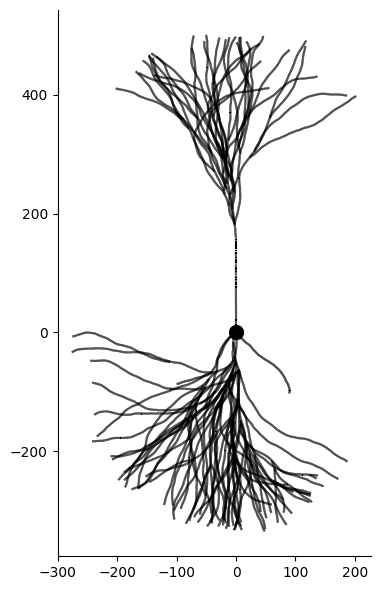

In [221]:
figure(figsize=(6, 6))
ax = PyPlot.axes()
for i in 1:5
    if i == 1
        lines, pos = segments_lines(tree_infos[i], seg_vecs[i]);
    elseif i == 2
        lines, _ = segments_lines(tree_infos[i], seg_vecs[i], pos[end, :]);
    else
        lines, _ = segments_lines(tree_infos[i], seg_vecs[i]);
    end
    #linewidths = range(maxwidth, minwidth, length=length(lines));
    line_segments = matplotlib.collections.LineCollection(lines, color="k")
    #line_segments = matplotlib.collections.LineCollection(lines, linewidths=linewidths, color="k")
    ax.add_collection(line_segments)
end
ax.set_aspect("equal")
scatter(0, 0, s=100, color="k")
tight_layout()